# 读取广告数据

In [100]:
%matplotlib inline

import pandas as pd
import re
import sys
import random
import numpy as np
from numpy import delete
from numpy import linalg as LA
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import networkx as nx
import statsmodels.api as sm
from collections import Counter, defaultdict
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  

In [97]:
# df = pd.read_excel(open(filename,'rb'), sheetname=0)
# XLRDError: Unsupported format, or corrupt file: Expected BOF record; found '\xef\xbb\xbf<?xml'

In [98]:
# import xlrd
# xlrd.__VERSION__
# data = xlrd.open_workbook(filepath)
# XLRDError: Unsupported format, or corrupt file: Expected BOF record; found '\xef\xbb\xbf<?xml'

In [24]:
filename='/Users/chengjun/百度云同步盘/Writing/yangzhouTvAds/扬州新闻综合11.18-12.18广告数据/1118扬州新闻综合_商业广告详细.xls'

with open(filename,'rb') as f:
    data = f.readlines()

In [25]:
data[0]

'\xef\xbb\xbf<?xml version="1.0"?>\r\n'

In [92]:
data[:20]

['\xef\xbb\xbf<?xml version="1.0"?>\r\n',
 '<?mso-application progid="Excel.Sheet"?>\r\n',
 '<Workbook xmlns="urn:schemas-microsoft-com:office:spreadsheet"\r\n',
 ' xmlns:o="urn:schemas-microsoft-com:office:office"\r\n',
 ' xmlns:x="urn:schemas-microsoft-com:office:excel"\r\n',
 ' xmlns:ss="urn:schemas-microsoft-com:office:spreadsheet"\r\n',
 ' xmlns:html="http://www.w3.org/TR/REC-html40">\r\n',
 ' <DocumentProperties xmlns="urn:schemas-microsoft-com:office:office">\r\n',
 '  <Created>1996-12-17T01:32:42Z</Created>\r\n',
 '  <LastSaved>2013-04-16T01:07:53Z</LastSaved>\r\n',
 '  <Version>12.00</Version>\r\n',
 ' </DocumentProperties>\r\n',
 ' <OfficeDocumentSettings xmlns="urn:schemas-microsoft-com:office:office">\r\n',
 '  <AllowPNG/>\r\n',
 '  <RemovePersonalInformation/>\r\n',
 ' </OfficeDocumentSettings>\r\n',
 ' <ExcelWorkbook xmlns="urn:schemas-microsoft-com:office:excel">\r\n',
 '  <WindowHeight>4530</WindowHeight>\r\n',
 '  <WindowWidth>8505</WindowWidth>\r\n',
 '  <WindowTopX>4

In [93]:
import pandas as pd
from xml.sax import ContentHandler, parse

# Reference https://goo.gl/KaOBG3
# http://stackoverflow.com/questions/33470130/read-excel-xml-xls-file-with-pandas

class ExcelHandler(ContentHandler):
    def __init__(self):
        self.chars = [  ]
        self.cells = [  ]
        self.rows = [  ]
        self.tables = [  ]
    def characters(self, content):
        self.chars.append(content)
    def startElement(self, name, atts):
        if name=="Cell":
            self.chars = [  ]
        elif name=="Row":
            self.cells=[  ]
        elif name=="Table":
            self.rows = [  ]
    def endElement(self, name):
        if name=="Cell":
            self.cells.append(''.join(self.chars))
        elif name=="Row":
            self.rows.append(self.cells)
        elif name=="Table":
            self.tables.append(self.rows)

excelHandler = ExcelHandler()
parse(filename, excelHandler)
rows = excelHandler.tables[0][2:]
colNames = excelHandler.tables[0][1][:-1]
df1 = pd.DataFrame(rows, columns=colNames)

In [87]:
len(excelHandler.tables[0][2])

17

In [88]:
len(excelHandler.tables[0][1])

18

In [89]:
print ','.join(excelHandler.tables[0][1])

序号,结果名称,播出时间,广告时长(秒),结果类型,属性一,属性二,属性三,画源性质,消费人群,价格标注,商品销售企业归属,表现方式,画面形式,宣传内容,宣传形式,主持人,详细内容


In [94]:
print ','.join(excelHandler.tables[0][1][:-1])

序号,结果名称,播出时间,广告时长(秒),结果类型,属性一,属性二,属性三,画源性质,消费人群,价格标注,商品销售企业归属,表现方式,画面形式,宣传内容,宣传形式,主持人


In [90]:
print ','.join(excelHandler.tables[0][2])

1,华天宝桂龙药膏,2015-11-18 17:07:36-17:12:37,301,广告,商业广告,药品类,风湿及骨病药,,,,,,,,,


In [96]:
df1.head()

,序号,结果名称,播出时间,广告时长(秒),结果类型,属性一,属性二,属性三,画源性质,消费人群,价格标注,商品销售企业归属,表现方式,画面形式,宣传内容,宣传形式,主持人
0,1,华天宝桂龙药膏,2015-11-18 17:07:36-17:12:37,301,广告,商业广告,药品类,风湿及骨病药,,,,,,,,,
1,2,扬州华东慧康医院,2015-11-18 17:12:37-17:13:07,29,广告,商业广告,商业及服务性行业类,医疗/保健机构,,,,,,,,,
2,3,扬州京城皮肤病医院,2015-11-18 17:13:13-17:13:28,14,广告,商业广告,商业及服务性行业类,医疗/保健机构,,,,,,,,,
3,4,中国梦酒,2015-11-18 17:13:28-17:13:53,25,广告,商业广告,酒类,中国餐酒,,,,,,,,,
4,5,双沟金牡丹,2015-11-18 17:13:54-17:14:23,28,广告,商业广告,酒类,中国餐酒,,,,,,,,,


## 注意：只有 扬州新闻综合11.18-12.18广告数据，没有其他频道的数据！

# 读取收视数据   

In [101]:
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()
    
def loadData(data_path):
    with open(data_path) as f:
        data = f.readlines()

    dat = defaultdict(list)
    for line in data:
        if line != '\r\n':
            line = line.split("|")
            fid = line[0]
            time = line[1].strip()
            program = line[4].strip().decode("gb18030")
            dat[fid].append((time, program))
    return dat


In [102]:
dat = loadData("/Users/chengjun/百度云同步盘/Writing/yangzhouTvAds/扬州原始数据11.18-12.18/20151118.txt")

In [103]:
len(dat)

21030

In [105]:
for i in dat.values()[0][:10]:
    a, b = i
    print a, b

2015-11-18 09:03:21 扬州城市
2015-11-18 09:03:29 CCTV-4
2015-11-18 10:16:50 CCTV-6
2015-11-18 11:44:02 CCTV-4
2015-11-18 12:48:02 CCTV-6
2015-11-18 12:57:14 CCTV-7
2015-11-18 12:57:22 CCTV-9纪录
2015-11-18 13:09:22 CCTV-10
2015-11-18 13:19:30 CCTV-12
2015-11-18 13:22:10 江苏影视


### 如何识别关机又开机的情况？

In [106]:
from pandas import Timestamp, Timedelta

def switching(watchlist):
    # dat.values()[0]
    d = pd.DataFrame(watchlist, columns=['time', 'program'])
    d['time'] = [Timestamp(i) for i in d['time'] ] 
    d = d.sort('time') 
    d.index = range(len(d))
    length = []
    for index in range(len(d.time)):
        try:
            length.append(d.time[index+1]-d.time[index])
        except:
            length.append(Timedelta('0 days 00:10:01'))
    d['length'] = length
    d = d[d.length > Timedelta('0 days 00:10:00')] # 集中观看超过10分钟，否则认为只是在换台
    d = d[d.length < Timedelta('0 days 05:00:00')] # 没有持续看一个频道超过五个小时，否则认为离开了。
    d = d[d.program != ""] # 没有持续看一个频道超过五个小时，否则认为离开了。

    return d

In [114]:
watchlist = dat.values()[105]
d1 = pd.DataFrame(watchlist, columns=['time', 'program'])
d2 = switching(watchlist)
d2[:5]

/Users/chengjun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,time,program,length
14,2015-11-18 12:34:51,CCTV-4,00:41:43
56,2015-11-18 13:38:03,CCTV-4,00:14:00
62,2015-11-18 13:55:07,扬州新闻,04:10:40
64,2015-11-18 18:05:56,扬州城市,00:13:19
66,2015-11-18 18:20:43,扬州城市,00:20:32


In [113]:
d1[:3]

,time,program
0,2015-11-18 06:30:01,扬州新闻
1,2015-11-18 06:30:09,CCTV-10
2,2015-11-18 06:36:59,中视购物


In [109]:
d1.describe()

,time,program
count,119,119
unique,119,43
top,2015-11-18 06:40:49,扬州新闻
freq,1,13


In [111]:
dat.keys()[:5]

['000e0989ab66',
 '000e0989400d',
 '000e0989ab65',
 '000e09896c39',
 '000e098f14b2']

In [119]:
dat.values()[1], dat.keys()[1]

([], '000e0989400d')

In [117]:
u = dat.keys()[2]
d = switching(dat[u])
p = d.program
for i, j in zip(p[:-1],p[1:]):
    print i,j

CCTV-6 CCTV-6
CCTV-6 CCTV-8
CCTV-8 江苏教育
江苏教育 安徽卫视
安徽卫视 CCTV-6
CCTV-6 CCTV-5
CCTV-5 扬州新闻
扬州新闻 扬州城市
扬州城市 扬州生活


/Users/chengjun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [121]:
W = defaultdict(lambda:0)

n = 0
for u in dat:
    n+=1
    if n % 10**2 == 0:
        flushPrint(n)
    try:
        d = switching(dat[u])
        p = d.program
    except Exception, e:
        flushPrint(e)
    for i,j in zip(p[:-1],p[1:]):
        if i!=j:
            W[(i,j)] +=1

G = nx.Graph()
for x,y in W:
    if W[(x, y)] > 1:
        G.add_edge(x,y)


invalid type comparison

/Users/chengjun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


21000

In [122]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 109\nNumber of edges: 2091\nAverage degree:  38.3670'

In [123]:
d = nx.density(G)
print 'density is ', d

density is  0.355249745158


In [124]:
dg = nx.diameter(G)
print "diameter is", dg

diameter is 4


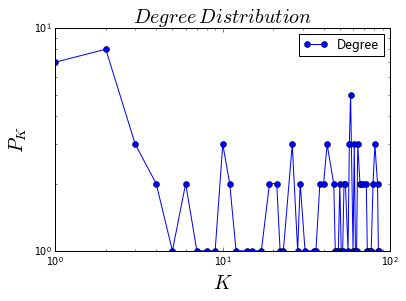

In [126]:
def plotDegreeDistribution(G):
    degs = defaultdict(int)
    for i in G.degree().values(): degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    plt.plot(x, y, 'b-o')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()   
    
plotDegreeDistribution(G)

In [127]:
MG = nx.minimum_spanning_tree(G)

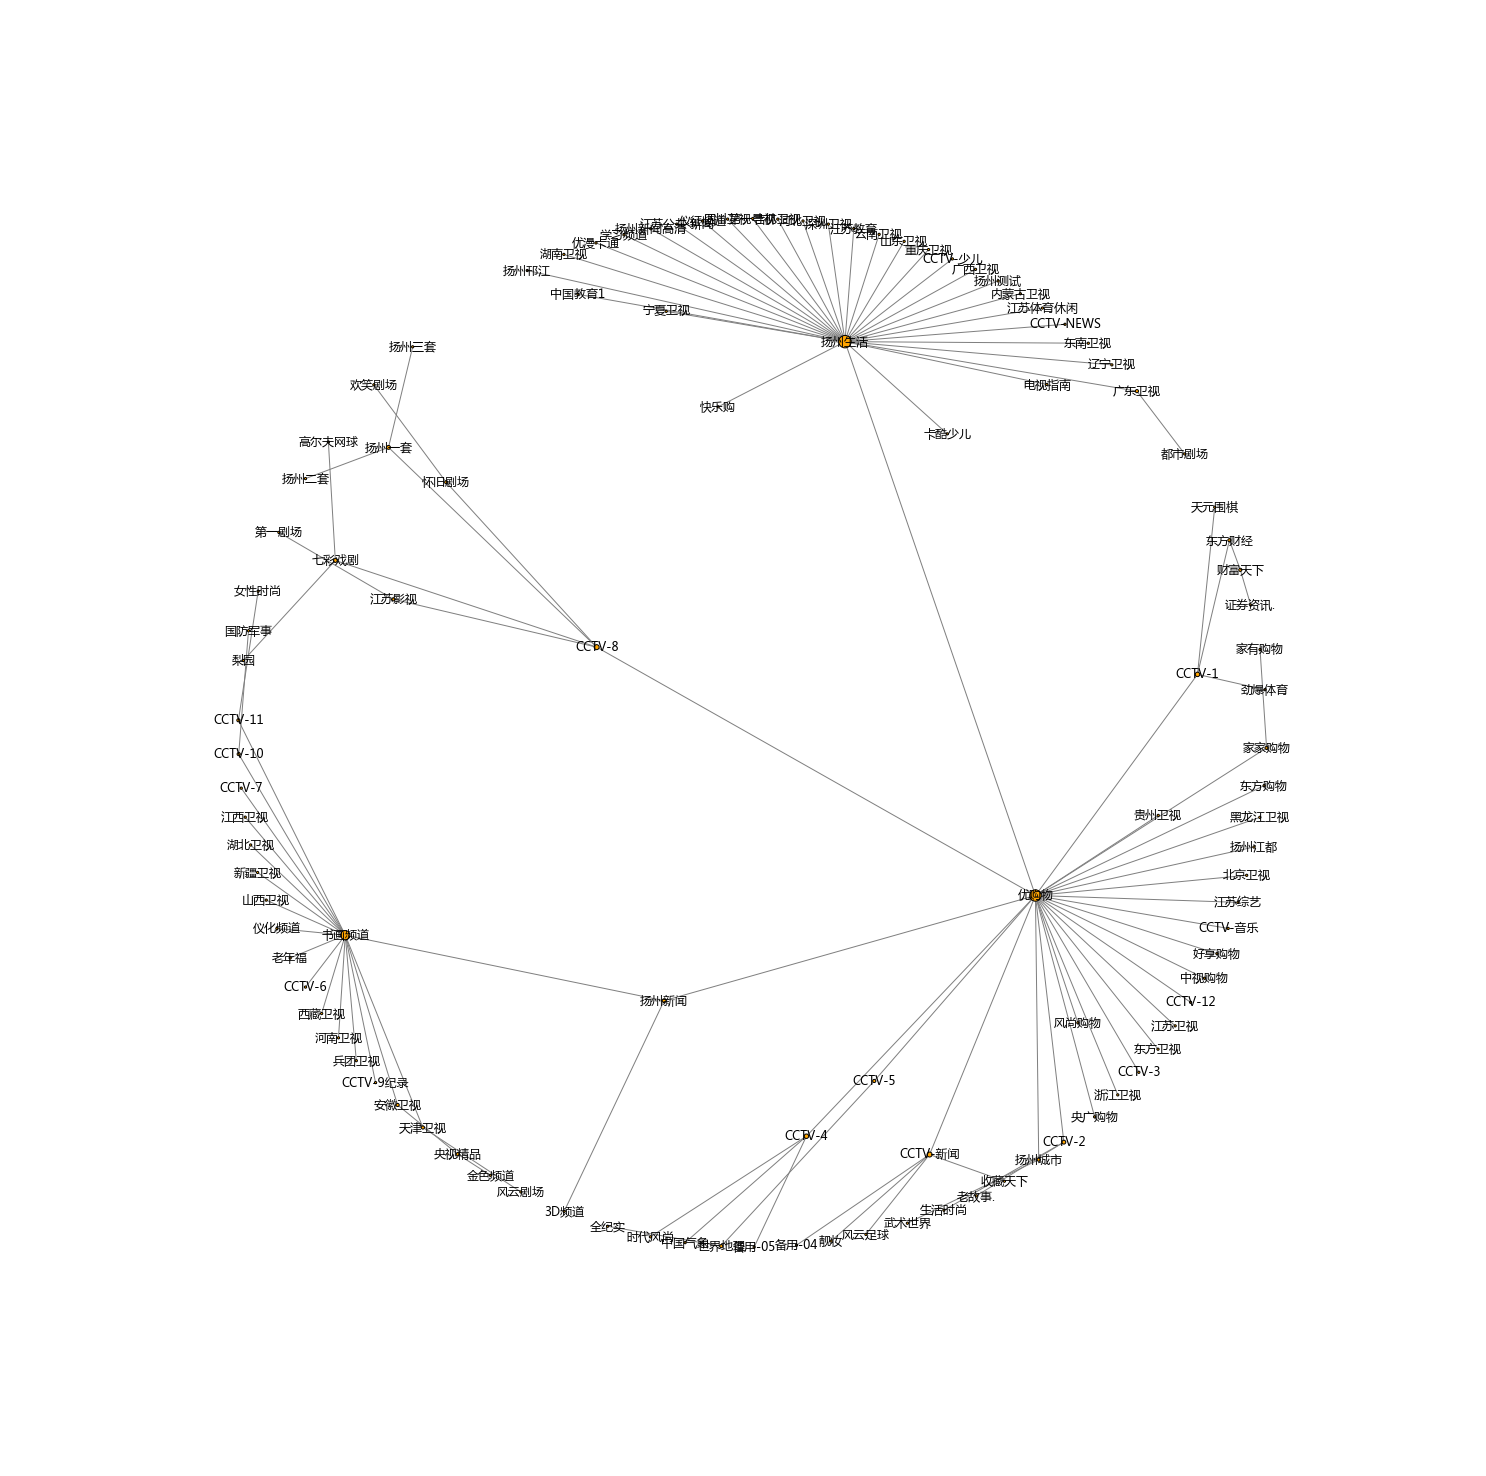

In [128]:
d = MG.degree() #计算节点的中心度
pos=nx.fruchterman_reingold_layout(MG,iterations=10000) #设置网络的布局
#spring_layout(MG,iterations=10000) #设置网络的布局

plt.rcParams['figure.figsize'] = (20, 20)  
nx.draw(MG, pos, node_color = 'orange', with_labels = True,
        nodelist = d.keys(), node_size = [v*5 for v in d.values()],
        edge_color = 'grey', width = 1, edge_cmap=plt.cm.Blues)

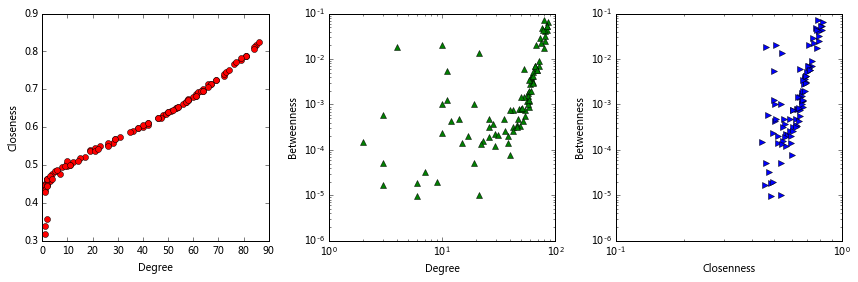

In [129]:
degree = nx.degree(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

#plt.rcParams['figure.figsize'] = (5, 5) 
fig = plt.figure(figsize=(12, 4),facecolor='white')
ax = fig.add_subplot(1,3,1)
plt.plot(degree.values(),closeness.values(),  'ro')
plt.xlabel(r'Degree'), plt.ylabel(r'Closeness')
ax = fig.add_subplot(1,3,2)
plt.plot(degree.values(), betweenness.values(), 'g^')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Degree'), plt.ylabel(r'Betweenness')
ax = fig.add_subplot(1,3,3)
plt.plot(closeness.values(), betweenness.values(), 'b>')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'Closenness'), plt.ylabel(r'Betweenness')
plt.tight_layout()

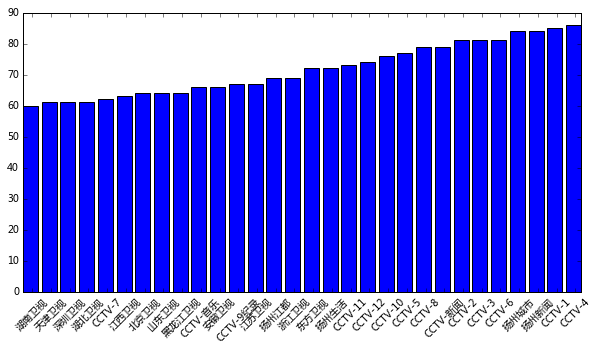

In [130]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
degree_table_sorted = sorted([(value, key) for (key, value) in degree.items()])
provinceFreq= [i[0] for i in degree_table_sorted][-30:]
provinceName = [unicode(i[1]) for i in degree_table_sorted][-30:]
position = np.arange(len(provinceName))
ax = fig.add_subplot(1,1,1)
ax = plt.axes()
ax.set_xticks(position +0.5)
ax.set_xticklabels(provinceName,  rotation= 45) 
plt.bar(position, provinceFreq)
plt.show()

# 为什么离开扬州新闻？